In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-07-25 23:13:41.525027: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 23:13:41.583585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 23:13:42.340357: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [3]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/XceptionNet'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Parameters
img_height, img_width = 299, 299  # InceptionV3 requires images of size 299x299
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [5]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))


In [6]:
# Split the dataset
create_splits()

In [7]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1425 images belonging to 5 classes.
Found 432 images belonging to 5 classes.
Found 450 images belonging to 5 classes.


In [10]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-07-25 23:13:53.084208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45735 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-07-25 23:14:05.466513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-07-25 23:14:05.960577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-25 23:14:06.153176: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f49df3e6d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-25 23:14:06.153206: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-07-25 23:14:06.158514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 23:14:06.320947: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

44/44 [==============================] - ETA: 0s - loss: 1.8889 - accuracy: 0.2204

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 37s 745ms/step - loss: 1.8889 - accuracy: 0.2204 - val_loss: 1.6132 - val_accuracy: 0.1899
Epoch 2/50
44/44 [==============================] - 32s 735ms/step - loss: 1.8227 - accuracy: 0.2218 - val_loss: 1.6065 - val_accuracy: 0.2308
Epoch 3/50
44/44 [==============================] - 32s 722ms/step - loss: 1.7609 - accuracy: 0.2391 - val_loss: 1.5980 - val_accuracy: 0.2404
Epoch 4/50
44/44 [==============================] - 31s 709ms/step - loss: 1.7004 - accuracy: 0.2563 - val_loss: 1.5972 - val_accuracy: 0.2332
Epoch 5/50
44/44 [==============================] - 32s 721ms/step - loss: 1.6747 - accuracy: 0.2757 - val_loss: 1.5918 - val_accuracy: 0.2572
Epoch 6/50
44/44 [==============================] - 32s 721ms/step - loss: 1.6474 - accuracy: 0.2958 - val_loss: 1.5919 - val_accuracy: 0.2716
Epoch 7/50
44/44 [==============================] - 32s 731ms/step - loss: 1.6511 - accuracy: 0.2670 - val_loss: 1.5917 - val_accuracy: 0.2716
Epoch 8/50

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 112ms/step - loss: 1.5789 - accuracy: 0.2844
Test accuracy: 0.28


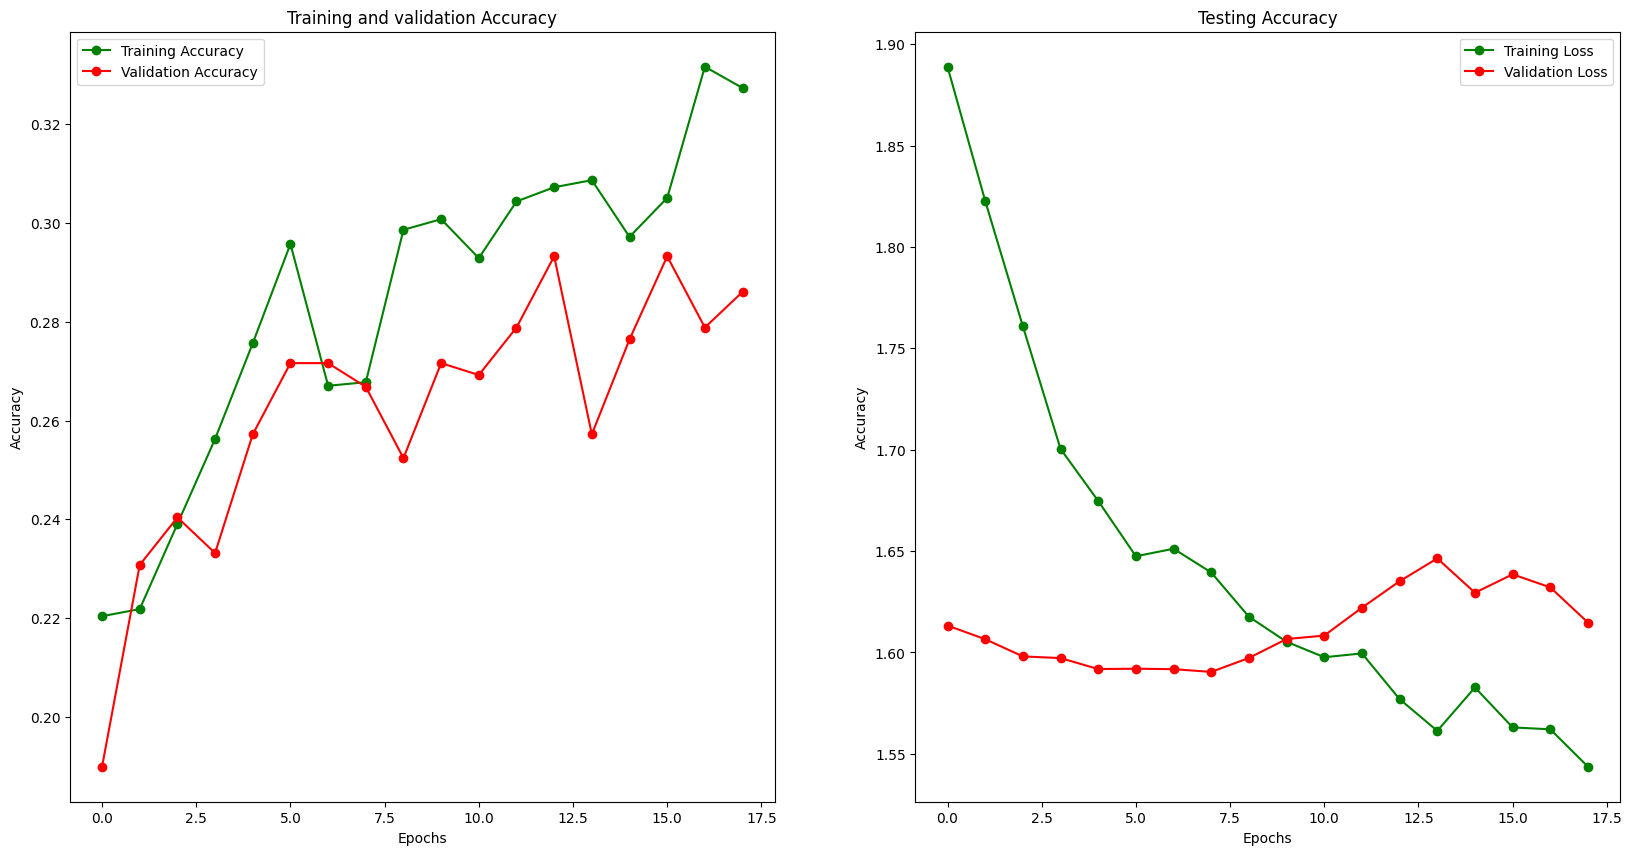

In [13]:
epochs = [i for i in range(18)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 3s 124ms/step


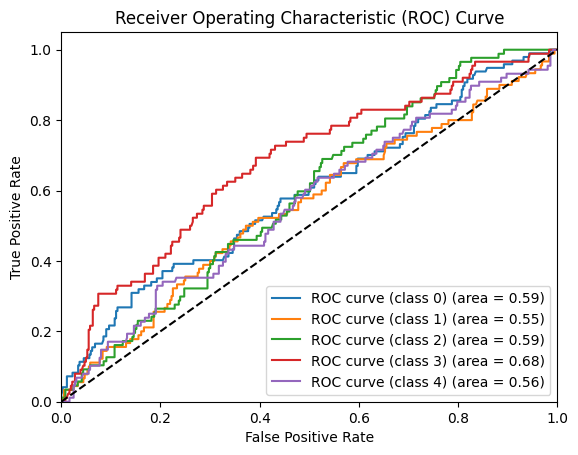

In [14]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

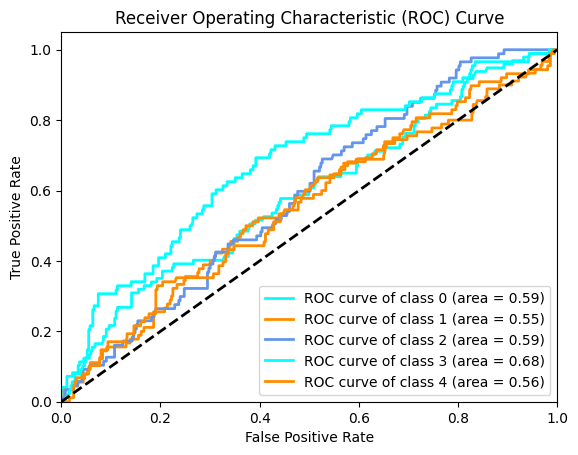

AUC for class 0: 0.59
AUC for class 1: 0.55
AUC for class 2: 0.59
AUC for class 3: 0.68
AUC for class 4: 0.56
Micro-average AUC: 0.59
Macro-average AUC: 0.60


In [15]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print out AUC values for each class
for i in range(num_classes):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')

# Print out micro and macro average AUC values
print(f'Micro-average AUC: {roc_auc["micro"]:.2f}')
print(f'Macro-average AUC: {roc_auc["macro"]:.2f}')

# Architetcure No 2

In [16]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
44/44 [==============================] - 31s 698ms/step - loss: 1.6318 - accuracy: 0.2814 - val_loss: 1.5857 - val_accuracy: 0.2957
Epoch 2/50
44/44 [==============================] - 32s 713ms/step - loss: 1.6130 - accuracy: 0.2929 - val_loss: 1.5803 - val_accuracy: 0.2909
Epoch 3/50
44/44 [==============================] - 31s 701ms/step - loss: 1.5860 - accuracy: 0.3044 - val_loss: 1.5950 - val_accuracy: 0.2909
Epoch 4/50
44/44 [==============================] - 31s 692ms/step - loss: 1.5890 - accuracy: 0.3001 - val_loss: 1.6018 - val_accuracy: 0.2933
Epoch 5/50
44/44 [==============================] - 31s 709ms/step - loss: 1.5873 - accuracy: 0.3044 - val_loss: 1.5812 - val_accuracy: 0.3101
Epoch 6/50
44/44 [==============================] - 31s 700ms/step - loss: 1.5820 - accuracy: 0.3080 - val_loss: 1.5822 - val_accuracy: 0.3101
Epoch 7/50
44/44 [==============================] - 31s 705ms/step - loss: 1.5792 - accuracy: 0.3238 - val_loss: 1.5778 - val_accuracy: 0.3053

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 100ms/step - loss: 1.5428 - accuracy: 0.3289
Test accuracy: 0.33


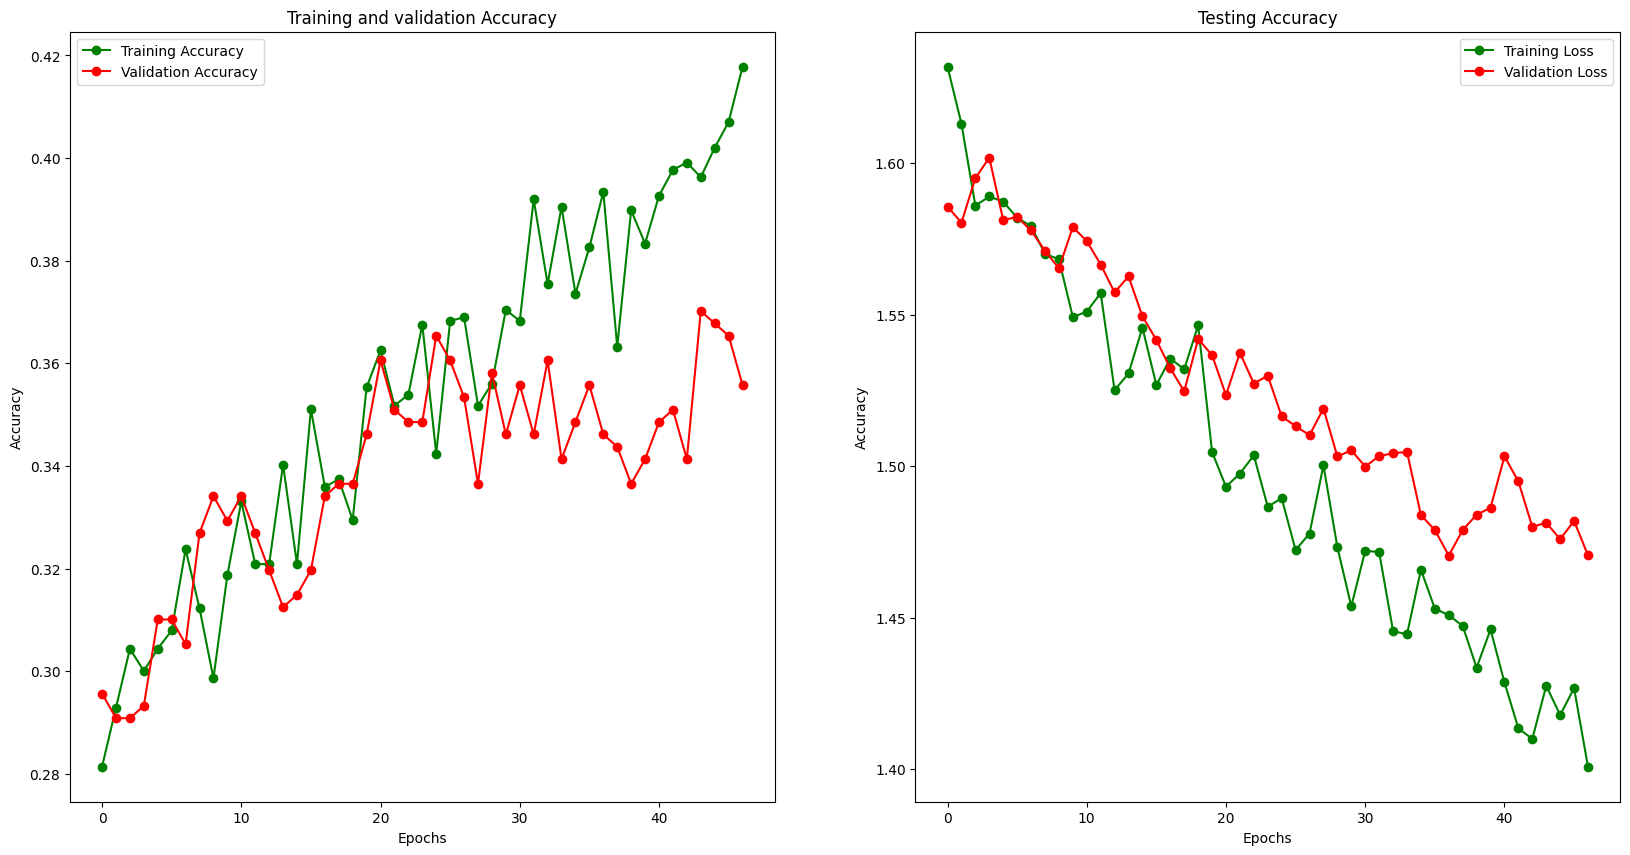

In [20]:
epochs = [i for i in range(47)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 2s 99ms/step


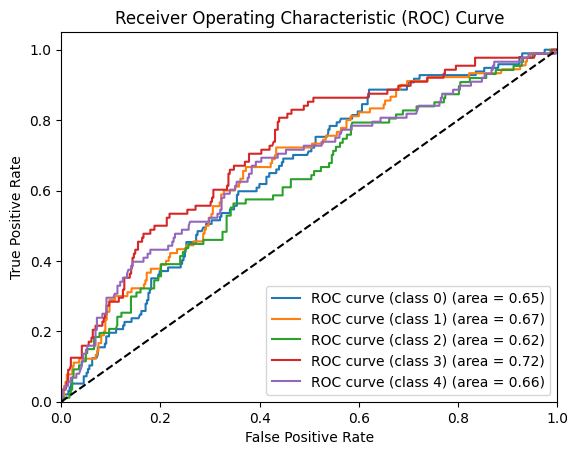

In [21]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 4

In [22]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.8424 - accuracy: 0.2599

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 36s 698ms/step - loss: 1.8424 - accuracy: 0.2599 - val_loss: 1.6121 - val_accuracy: 0.2236
Epoch 2/50
44/44 [==============================] - 31s 711ms/step - loss: 1.6654 - accuracy: 0.2994 - val_loss: 1.5731 - val_accuracy: 0.2668
Epoch 3/50
44/44 [==============================] - 31s 702ms/step - loss: 1.6297 - accuracy: 0.3044 - val_loss: 1.5578 - val_accuracy: 0.2909
Epoch 4/50
44/44 [==============================] - 30s 679ms/step - loss: 1.5449 - accuracy: 0.3403 - val_loss: 1.5639 - val_accuracy: 0.2788
Epoch 5/50
44/44 [==============================] - 30s 691ms/step - loss: 1.5015 - accuracy: 0.3582 - val_loss: 1.5386 - val_accuracy: 0.3197
Epoch 6/50
44/44 [==============================] - 31s 702ms/step - loss: 1.4710 - accuracy: 0.3912 - val_loss: 1.5084 - val_accuracy: 0.3582
Epoch 7/50
44/44 [==============================] - 31s 705ms/step - loss: 1.4569 - accuracy: 0.3733 - val_loss: 1.4790 - val_accuracy: 0.3365
Epoch 8/50

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 105ms/step - loss: 1.2216 - accuracy: 0.5378
Test accuracy: 0.54


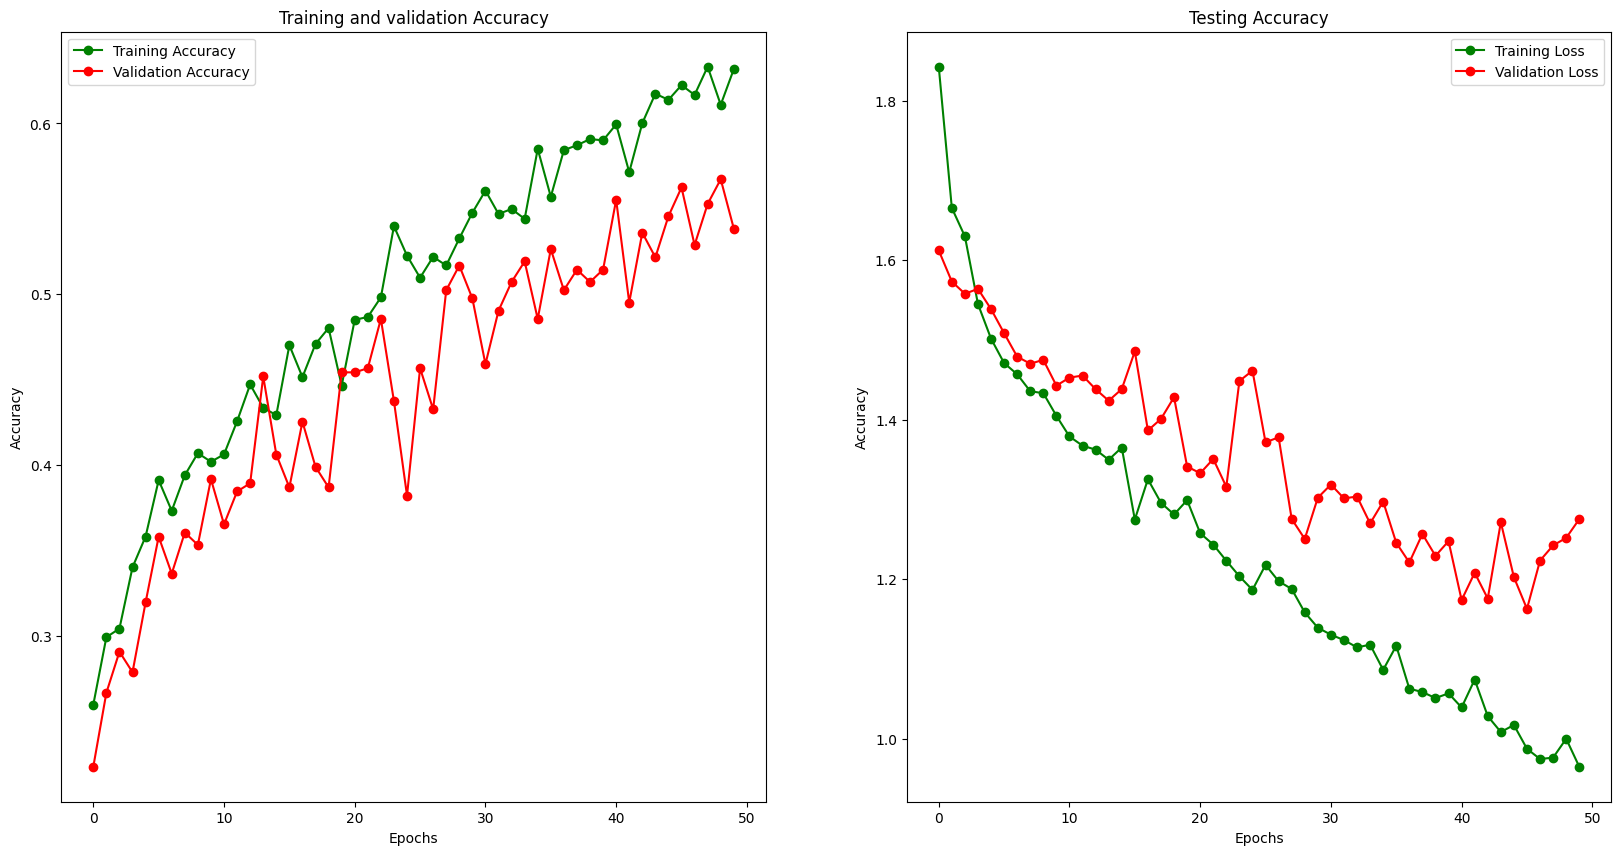

In [25]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 2s 94ms/step


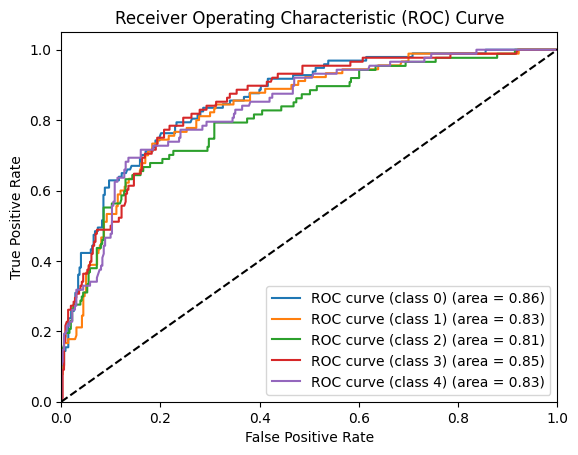

In [26]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No 5

In [27]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [28]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.8441 - accuracy: 0.2268

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 35s 700ms/step - loss: 1.8441 - accuracy: 0.2268 - val_loss: 1.5996 - val_accuracy: 0.2115
Epoch 2/50
44/44 [==============================] - 32s 721ms/step - loss: 1.6880 - accuracy: 0.2656 - val_loss: 1.5867 - val_accuracy: 0.2236
Epoch 3/50
44/44 [==============================] - 31s 716ms/step - loss: 1.5835 - accuracy: 0.3410 - val_loss: 1.5654 - val_accuracy: 0.2885
Epoch 4/50
44/44 [==============================] - 31s 714ms/step - loss: 1.5467 - accuracy: 0.3604 - val_loss: 1.5426 - val_accuracy: 0.2933
Epoch 5/50
44/44 [==============================] - 32s 724ms/step - loss: 1.5249 - accuracy: 0.3396 - val_loss: 1.5137 - val_accuracy: 0.3365
Epoch 6/50
44/44 [==============================] - 31s 700ms/step - loss: 1.4840 - accuracy: 0.3754 - val_loss: 1.5219 - val_accuracy: 0.3486
Epoch 7/50
44/44 [==============================] - 33s 741ms/step - loss: 1.4876 - accuracy: 0.3762 - val_loss: 1.4844 - val_accuracy: 0.3654
Epoch 8/50

In [30]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 95ms/step - loss: 1.1640 - accuracy: 0.5489
Test accuracy: 0.55


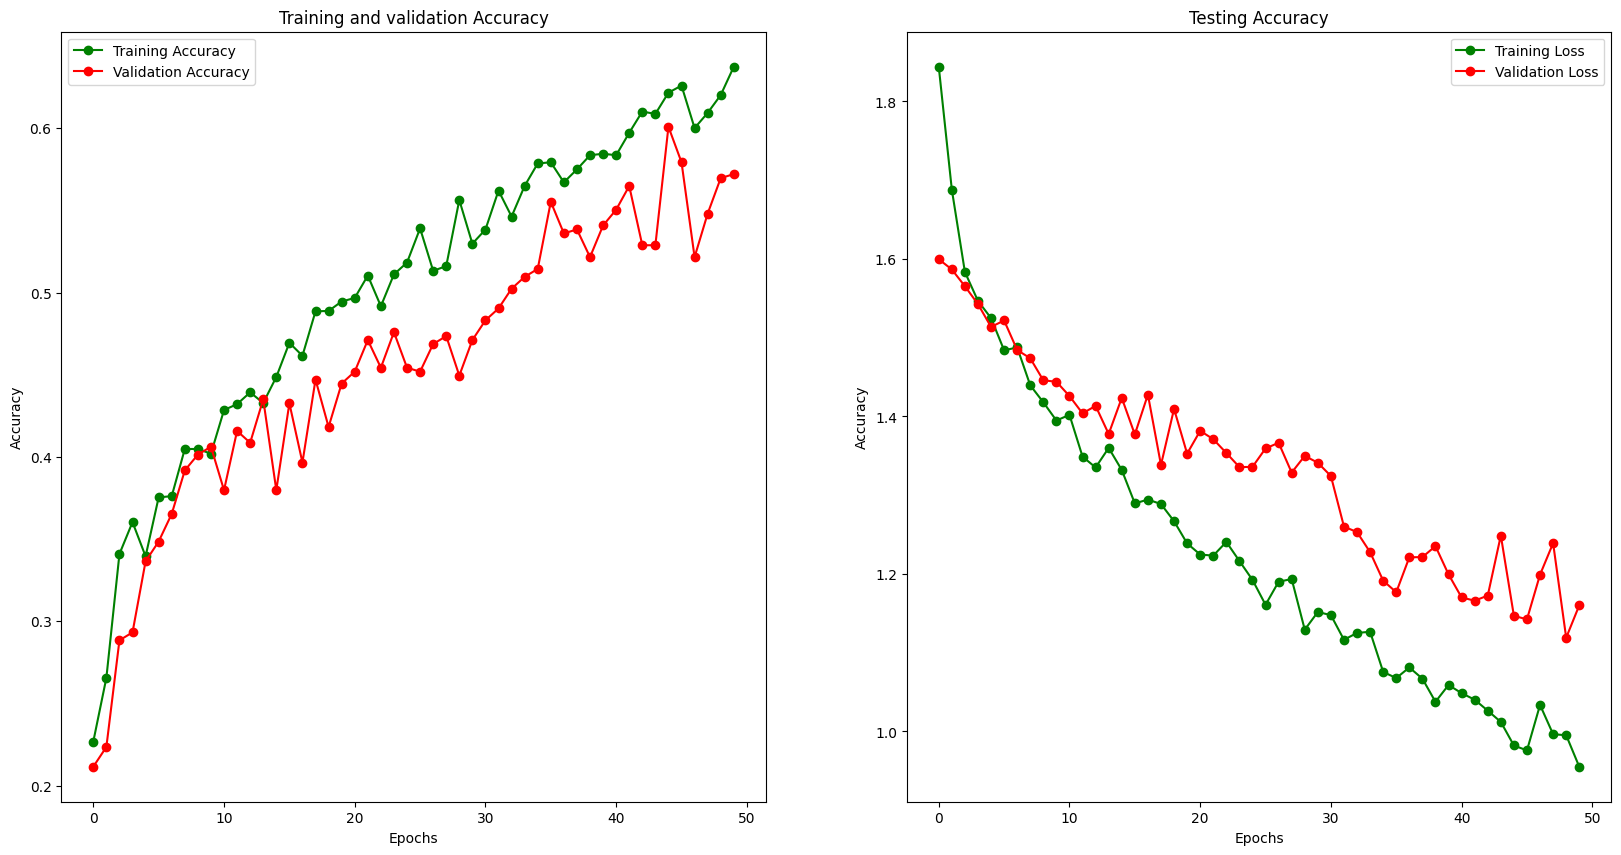

In [31]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 2s 92ms/step


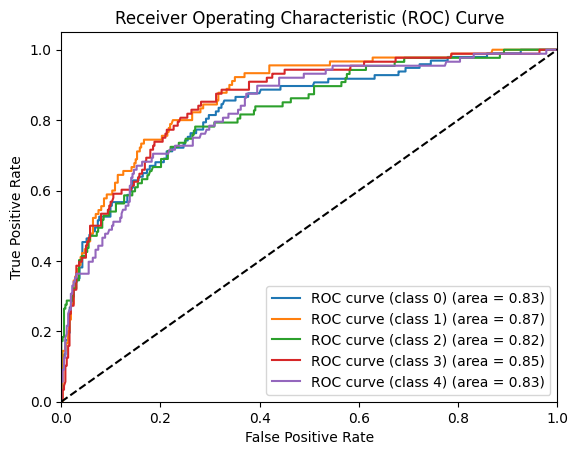

In [32]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 6

In [34]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [35]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.7827 - accuracy: 0.2484

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 35s 692ms/step - loss: 1.7827 - accuracy: 0.2484 - val_loss: 1.5944 - val_accuracy: 0.2668
Epoch 2/50
44/44 [==============================] - 31s 708ms/step - loss: 1.6679 - accuracy: 0.2843 - val_loss: 1.5824 - val_accuracy: 0.2668
Epoch 3/50
44/44 [==============================] - 31s 710ms/step - loss: 1.6458 - accuracy: 0.2850 - val_loss: 1.5752 - val_accuracy: 0.2692
Epoch 4/50
44/44 [==============================] - 31s 704ms/step - loss: 1.5838 - accuracy: 0.2965 - val_loss: 1.5557 - val_accuracy: 0.3077
Epoch 5/50
44/44 [==============================] - 31s 702ms/step - loss: 1.5765 - accuracy: 0.2986 - val_loss: 1.5482 - val_accuracy: 0.3221
Epoch 6/50
44/44 [==============================] - 31s 701ms/step - loss: 1.5550 - accuracy: 0.3202 - val_loss: 1.5345 - val_accuracy: 0.3221
Epoch 7/50
44/44 [==============================] - 31s 694ms/step - loss: 1.5340 - accuracy: 0.3460 - val_loss: 1.5215 - val_accuracy: 0.3365
Epoch 8/50

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 96ms/step - loss: 1.2398 - accuracy: 0.4822
Test accuracy: 0.48


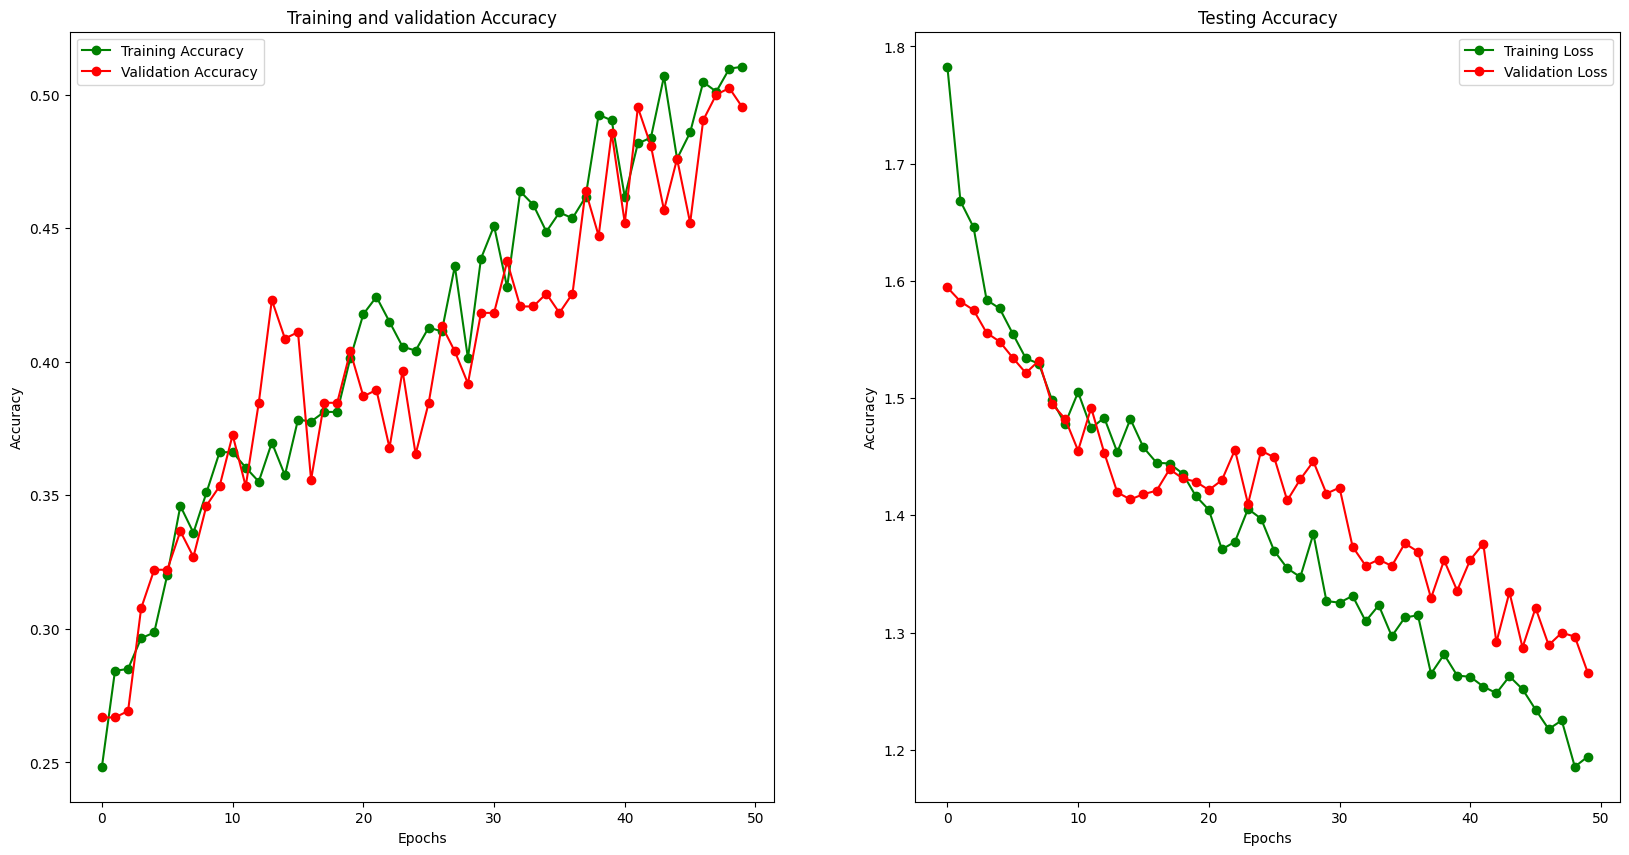

In [37]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 2s 98ms/step


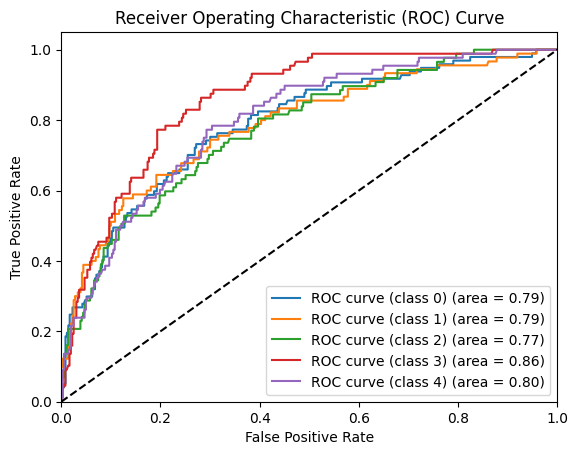

In [38]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Architecture No 7

In [39]:
# Load the InceptionV3 model pretrained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [40]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.7965 - accuracy: 0.2362

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 36s 721ms/step - loss: 1.7965 - accuracy: 0.2362 - val_loss: 1.5961 - val_accuracy: 0.2692
Epoch 2/50
44/44 [==============================] - 32s 736ms/step - loss: 1.6676 - accuracy: 0.2893 - val_loss: 1.5796 - val_accuracy: 0.2837
Epoch 3/50
44/44 [==============================] - 32s 735ms/step - loss: 1.6148 - accuracy: 0.3123 - val_loss: 1.5542 - val_accuracy: 0.3293
Epoch 4/50
44/44 [==============================] - 32s 735ms/step - loss: 1.6107 - accuracy: 0.2922 - val_loss: 1.5494 - val_accuracy: 0.3341
Epoch 5/50
44/44 [==============================] - 32s 723ms/step - loss: 1.5347 - accuracy: 0.3381 - val_loss: 1.5262 - val_accuracy: 0.3341
Epoch 6/50
44/44 [==============================] - 32s 724ms/step - loss: 1.5453 - accuracy: 0.3352 - val_loss: 1.5113 - val_accuracy: 0.3534
Epoch 7/50
44/44 [==============================] - 32s 733ms/step - loss: 1.5179 - accuracy: 0.3238 - val_loss: 1.4962 - val_accuracy: 0.3486
Epoch 8/50

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

15/15 [==============================] - 2s 100ms/step - loss: 1.2091 - accuracy: 0.5644
Test accuracy: 0.56


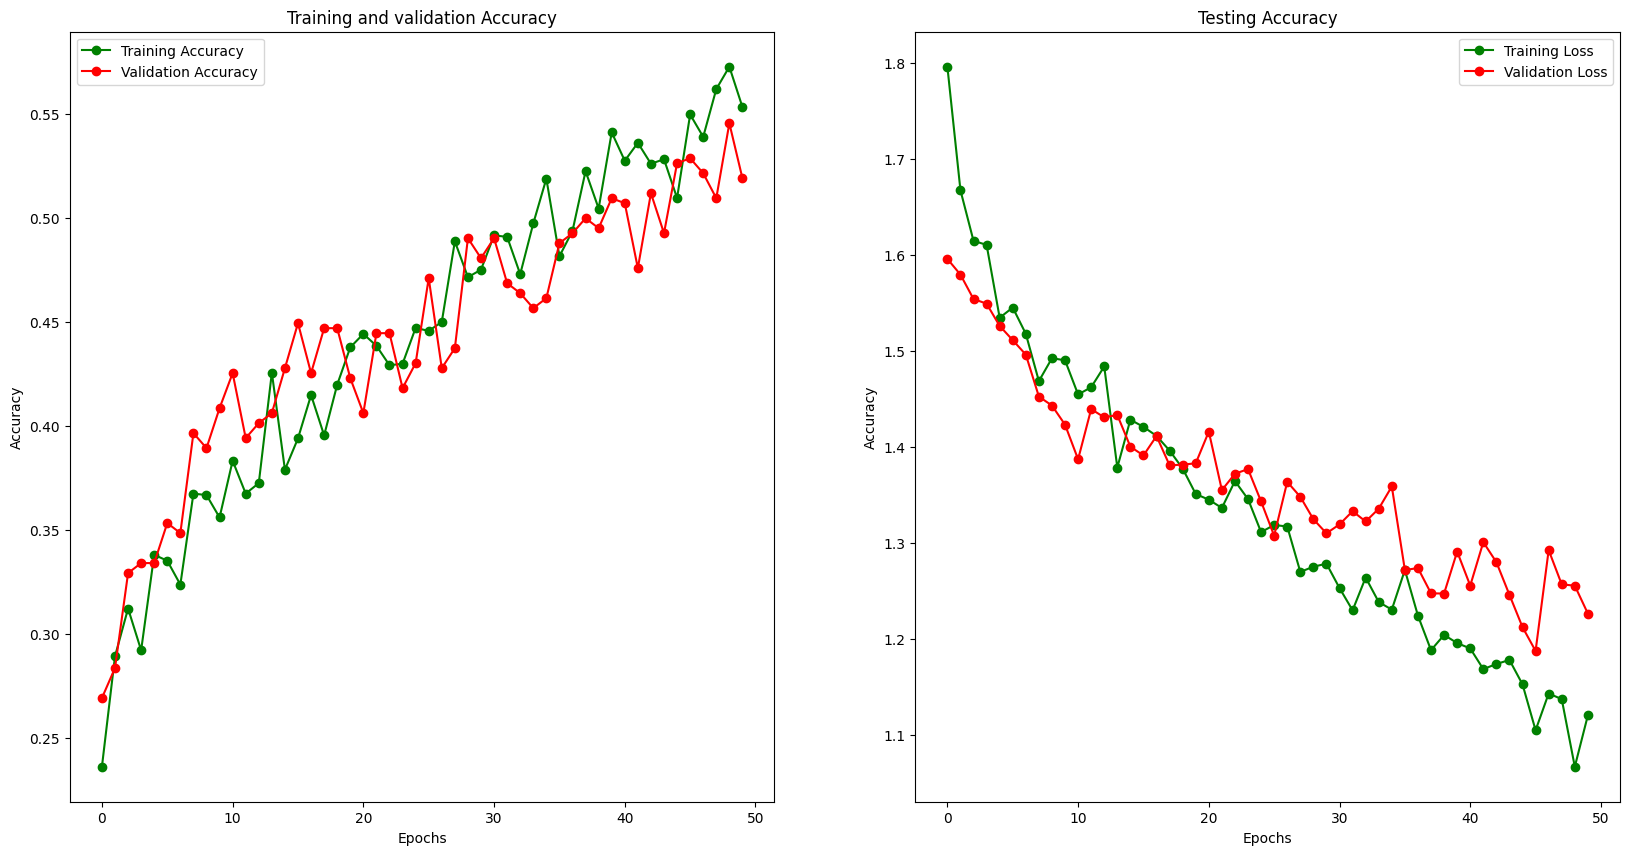

In [42]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

15/15 [==============================] - 2s 93ms/step


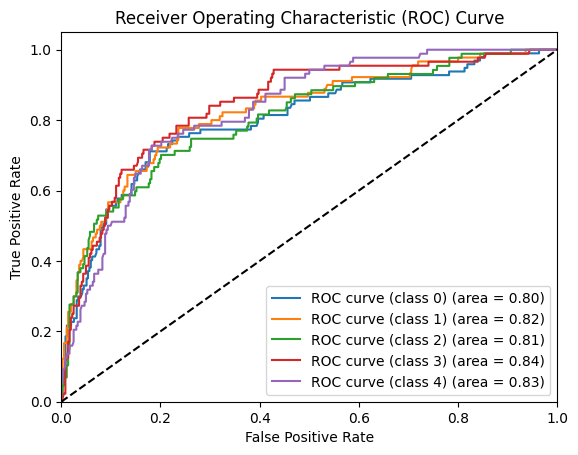

In [43]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
